### Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from linearmodels.asset_pricing import TradedFactorModel
from pypfopt import EfficientFrontier

import sys
sys.path.append('..')
from   Tools.Codigo import *

### Precios
- La base SP_yahoo.xlsx , contiene las 25 empresas con mayor weight en el índice Sp500

In [2]:
data = pd.read_excel('SPY_yahoo.xlsx').set_index('Date')

#### Verifico Indice

In [3]:
data.index

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-24',
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-31', '2020-09-01'],
              dtype='datetime64[ns]', name='Date', length=7730, freq=None)

### Inputs
- Construir un resample con datos mensuales

In [4]:
data_ = data.resample('M').mean()

#### Fechas
- Defino un punto 't' como punto de partida

In [5]:
t = '1999-01-05'

### Construir Factor
- from Tools.Codigo, utilizo la función momentum
- El factor se construye en base a la siguiente formula:
\[ WML = 1/2(Small High + Big High) - 1/2(Small Low + Big Low) \]
- Verificar el factor con un gráfico

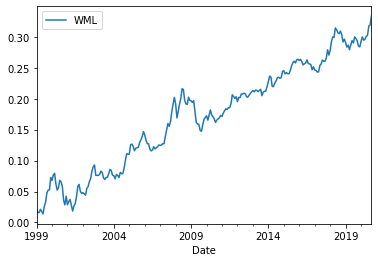

In [6]:
WML = momentum(data_,period=t,frequency=12)
((WML+1).cumprod()-1).plot()

### Benchmark
- Utilizo el SP500 como factor MktRF

In [7]:
MktRF = yf.download('SPY',start=t)['Adj Close'].to_frame('MktRF')
MktRF = MktRF.resample('M').mean()

[*********************100%***********************]  1 of 1 completed


### Window
- Defino una fecha start y end

In [8]:
start = '2000-01'
end = '2020-08'

### Retornos Logaritmicos
- Filtro la base de precios a partir de 't'
- Filtro la base de precios y MktRF con start y end

In [9]:
sample = np.log((data_/data_.shift(1)))[t:]
sample = sample[start:end].dropna(axis=1)
factor0 = np.log((MktRF/MktRF.shift(1)))[start:end]
factor1 = WML[start:end]

### Portfolio Single Period

#### Portafolio EW
- from Tools.Codigo, aplico un función alternativa para calcular los retornos históricos medios.
- A diferencia de métrica de retornos históricos (estimador insesgado pero ineficiente "en términos de asignación de varianza"), se puede mejorar el estimador con el método James-Stein Shrinkage.

- En donde: \[\hat{\gamma}_{JS} = \left(1-\frac{(m-3)\sigma^2}{||y||^2}\right)y\]

- Si $m>3$, $MSE_{James-Stein}$ < $MSE_{MaximumLikehood}$

#### Portfolio EW - Parametros

In [10]:
mu = JS_shrinkage(sample,frequency=12)
cov = sample.cov()*12
n = sample.shape[1]
w_ew = np.repeat(1/n, n)
EWPort = sample.mul(w_ew,axis=1).sum(axis=1)
EWRet = np.sum(mu*w_ew)
EWVol = np.sqrt(np.dot(w_ew.T,np.dot(cov,w_ew)))
print('Portfolio EW:')
print('Retorno     :',np.round(EWRet,5))
print('Volatilidad :',np.round(EWVol,5))

Portfolio EW:
Retorno     : 0.08234
Volatilidad : 0.12376


### Modelo Factorial Fama-MacBeth

- Método similar a Modelo CAPM. El modelo Fama-MacBeth estima las $\alpha_i$ y $\beta_i$ para cualquier $Factor_i$ de riesgo que se espera que determine los precios de los activos

In [11]:
# Nombre de columnas
tickers = list(sample.columns)
# Universo de inversion
assets = sample
# Factores
factors = pd.concat([factor0,factor1],axis=1).dropna()
# Modelo
mod = TradedFactorModel(assets, factors)
# Resultados
res = mod.fit()
print(res)

                      TradedFactorModel Estimation Summary                      
No. Test Portfolios:                 21   R-squared:                      0.3406
No. Factors:                          2   J-statistic:                    37.911
No. Observations:                   248   P-value                         0.0132
Date:                  Mon, Sep 07 2020   Distribution:                 chi2(21)
Time:                          18:59:42                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MktRF          0.0050     0.0025     2.0102     0.0444      0.0001      0.0099
WML            0.0009     0.0004    

#### Parametros del Modelo

In [12]:
print(res.params)

          alpha     MktRF       WML
MSFT   0.001862  0.978717  0.762575
AAPL   0.007976  1.555578  5.076113
AMZN   0.006494  1.321609  1.496422
BRK-B  0.004940  0.564066 -0.703161
JNJ    0.004265  0.505227  0.050780
JPM    0.000035  1.253730 -1.368595
PG     0.005090  0.369726 -0.848640
INTC  -0.004287  1.246040  0.851423
UNH    0.013578  0.636934 -0.485355
BAC   -0.002838  1.485004 -2.046188
T      0.000036  0.592937 -1.293326
HD     0.001924  1.118873  0.235709
XOM   -0.001451  0.749095  0.387778
DIS    0.002779  1.166183 -1.751613
VZ     0.002163  0.544612 -1.018644
KO     0.002852  0.478461  0.039226
MRK    0.002276  0.534557 -1.395063
CMCSA  0.001539  0.920423 -1.285583
CVX    0.001589  0.843157  0.617820
PEP    0.005283  0.497128 -0.377135
PFE    0.001437  0.611578 -1.413788


#### Stock Picking
- Seleccion de Top 10 assets con mayor alpha ajustado por desvío

In [13]:
std = assets.std()
alpha = (res.alphas/std).sort_values(ascending=False).iloc[0:10]
print(alpha)

UNH      0.216933
PEP      0.139949
BRK-B    0.117502
JNJ      0.113592
PG       0.108053
AAPL     0.073255
KO       0.070742
AMZN     0.060707
VZ       0.044040
DIS      0.043948
dtype: float64


- Extraer labels

In [14]:
labels = list(alpha.index)
print(labels)

['UNH', 'PEP', 'BRK-B', 'JNJ', 'PG', 'AAPL', 'KO', 'AMZN', 'VZ', 'DIS']


- List comprenhension para ordenar la lista de "labels" y poder matchear con el orden de las columnas de "tickers"

In [15]:
k = [k for k in tickers if k in labels]
k

['AAPL', 'AMZN', 'BRK-B', 'JNJ', 'PG', 'UNH', 'DIS', 'VZ', 'KO', 'PEP']

- Una vez ordenada la lista "labels", puedo filtar los retornos de "sample"

In [16]:
ret_sample = sample[k]
ret_sample.head()

,AAPL,AMZN,BRK-B,JNJ,PG,UNH,DIS,VZ,KO,PEP
Date,,,,,,,,,,
2000-01-31,-0.000398,-0.291397,-0.024391,-0.052293,-0.009671,0.096336,0.188657,-0.083019,-0.000942,-0.000450
2000-02-29,0.077052,0.062826,-0.085731,-0.128609,-0.153195,-0.015487,0.048381,-0.066224,-0.126543,-0.058498
2000-03-31,0.140686,-0.082889,0.012414,-0.058848,-0.395681,-0.057166,0.048169,0.062410,-0.120263,-0.030431
2000-04-30,-0.042910,-0.168155,0.152407,0.062305,0.037362,0.204230,0.080266,0.076018,0.019333,0.121883
2000-05-31,-0.199799,-0.048727,-0.024081,0.098899,-0.010699,0.094077,0.002854,-0.150446,0.044855,0.061670


- Covarianza y Retornos

In [17]:
cov_sample = ret_sample.cov()
mu_sample = JS_shrinkage(ret_sample,frequency=12)

- from pypfopt import EfficientFrontier obtengo un método para calcular ${weights}^*$

In [18]:
# Método para obtener weights*
efOpt = EfficientFrontier(mu_sample,cov_sample)

# Diccionario de weights
wdicc = efOpt.min_volatility().values() #Si saco .values() veo que cuales son los tickers

# Lista de weights
weights = []

# Append de Dicc.values a Lista
for v in wdicc:
    weights.append(v)

weights = np.array(weights)
weights

array([0.03472588, 0.00253091, 0.20990315, 0.21403311, 0.09062892,
       0.01991626, 0.        , 0.1505788 , 0.17655682, 0.10112615])

#### Portfolio MinVar

In [19]:
MinVarPort = ret_sample.mul(weights,axis=1).sum(axis=1)
MinVarRet = np.sum(mu_sample*weights)
MinVarVol = np.sqrt(np.dot(weights.T,np.dot(cov_sample,weights)))
print('MinVar. Portfolio:')
print('Retorno          :',np.round(MinVarRet,5))
print('Volatilidad      :',np.round(MinVarVol,5))

MinVar. Portfolio:
Retorno          : 0.08257
Volatilidad      : 0.02954


### Performance 
- Contraste Single Period entre MinVar. Portfolio, Equally Weighted Portfolio y Benchmark

In [20]:
Backtest = pd.concat([MinVarPort,EWPort,factor0],axis=1)
Backtest.columns = ['MinVarPort','EWPort','Benchmark']
Backtest

,MinVarPort,EWPort,Benchmark
Date,,,
2000-01-31,-0.028734,-0.015391,-0.002256
2000-02-29,-0.095109,-0.033751,-0.026203
2000-03-31,-0.057226,-0.010232,0.040327
2000-04-30,0.078049,0.035081,0.013145
2000-05-31,0.001457,-0.029349,-0.029971
...,...,...,...
2020-04-30,0.040179,0.046768,0.043184
2020-05-31,-0.013000,0.033493,0.057307
2020-06-30,0.019410,0.039004,0.063087


#### Visualización

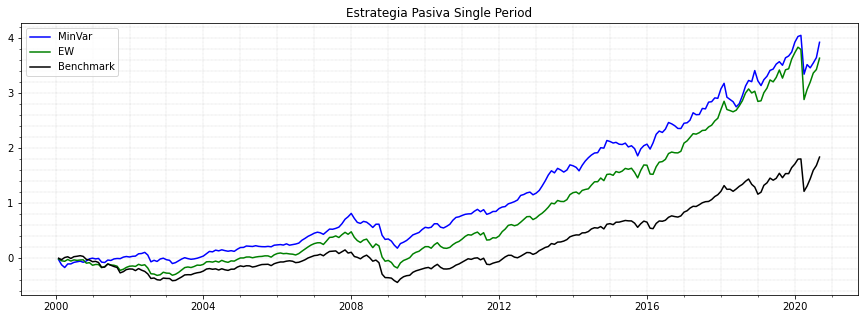

In [21]:
plt.figure(figsize=(15,5))
plt.title('Estrategia Pasiva Single Period')
plt.plot(((1+Backtest.iloc[:,0]).cumprod()-1),c="b",ls="-",lw=1.5,label='MinVar')
plt.plot(((1+Backtest.iloc[:,1]).cumprod()-1),c="g",ls="-",lw=1.5,label='EW')
plt.plot(((1+Backtest.iloc[:,2]).cumprod()-1),c="k",ls="-",lw=1.5,label='Benchmark')
plt.minorticks_on()
plt.grid(which='major',linestyle=':',linewidth='0.3',color='grey')
plt.grid(which='minor',linestyle=':',linewidth='0.3',color='grey')
plt.legend()
plt.show()

### Portfolio Multiperiod 
- Rebalanceo Mensual

In [22]:
#Universo de activos
InvestUniverse = list(assets.columns)
#Vector de Holdings
Holdings = []
#Weights
AllWi = []

- For loop para extraer labels

In [23]:
for i in range(0,len(assets)-12):
    print(i)
    
    #Depuración de activos NA
    na_id = assets.iloc[(0+i):(12+i),].mean().isna()
    na_id = na_id[na_id == False]
    
    #Subset
    retSubset = assets.iloc[(0+i):(12+i),]
    if len(na_id) > 0:
        retSubset = assets.iloc[(0+i):(12+i),][na_id.index]
   
    #Regresión
    Y = retSubset
    f0 = factor0.loc[Y.index,]
    f1 = factor1.loc[Y.index,]
    X = pd.concat([f0,f1],axis=1)
    
    # Modelo
    mod = TradedFactorModel(Y,X)
    
    # Resultados
    res = mod.fit()

    # Desvío de cada serie de tiempo
    std = Y.std()
    
    # Alfa ajustado por Desvío
    alpha = (res.alphas/std).sort_values(ascending=False).iloc[0:10]
    
    # Alpha labels
    label = list(alpha.index)
    
    # List comprenhension para matchear labels en el orden de tickers
    k = [k for k in InvestUniverse if k in label]
    
    #Append cada elemento de k en una lista
    Holdings.append(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235


- Ajuste de weights para cada momento del periodo analizado

In [24]:
# Iteración para cada Holding con el fin de extraer weights
for i in Holdings:
        
    # Filtro la Base por cada Holding
    ret_sample = assets[i]
        
    # Calculo la covarianza del Filtro
    cov_sample = ret_sample.cov()
        
    # Calculo los retornos promedios ajustados por estimador JS
    mu_sample = JS_shrinkage(ret_sample,frequency=12)
        
    # Metodo para calcular los weights
    efOpt = EfficientFrontier(mu_sample,cov_sample)
    weights = efOpt.min_volatility().values()
    w = []
    for i in weights:
        w.append(i)
    w = np.array(w)
    AllWi.append(w)

In [25]:
Holdings[0:5]

[['BRK-B', 'JNJ', 'JPM', 'INTC', 'UNH', 'XOM', 'DIS', 'MRK', 'PEP', 'PFE'],
 ['BRK-B', 'JNJ', 'JPM', 'INTC', 'UNH', 'BAC', 'T', 'MRK', 'PEP', 'PFE'],
 ['BRK-B', 'JNJ', 'JPM', 'UNH', 'BAC', 'T', 'XOM', 'CVX', 'PEP', 'PFE'],
 ['BRK-B', 'JNJ', 'JPM', 'UNH', 'BAC', 'XOM', 'KO', 'MRK', 'PEP', 'PFE'],
 ['BRK-B', 'JNJ', 'JPM', 'UNH', 'BAC', 'XOM', 'KO', 'CMCSA', 'PEP', 'PFE']]

In [26]:
AllWi[0:5]

[array([0.23207067, 0.23842796, 0.        , 0.02984964, 0.01940636,
        0.13028323, 0.        , 0.0167742 , 0.26796636, 0.06522158]),
 array([0.22195733, 0.30044225, 0.        , 0.03436032, 0.03465212,
        0.        , 0.16949136, 0.        , 0.1839274 , 0.05516923]),
 array([0.21164473, 0.27251974, 0.        , 0.02784531, 0.        ,
        0.14520662, 0.08630137, 0.00472801, 0.2000452 , 0.05170902]),
 array([0.21959503, 0.21560864, 0.        , 0.01271478, 0.        ,
        0.11266426, 0.20199806, 0.        , 0.16065566, 0.07676358]),
 array([0.2125874 , 0.20482681, 0.        , 0.01339242, 0.        ,
        0.10350657, 0.19686194, 0.03676714, 0.16086309, 0.07119464])]

- Retornos [ t=12 ; T ]

In [27]:
returns = assets.iloc[12:,:]
returns.shape

(236, 21)

#### Portfolio rebalanceado

In [28]:
# Lista para appendear retornos rebalanceados
PortR = []
#PortRc = []

for i in range(0,len(AllWi)-1):
    # Cada fila de la matriz de Retornos es filtrada por Holding
    # Cada fila filtrada es multiplicada por el Weight Optimo
    # i+1 revita el Look Ahead Bias
    Result = np.sum(returns[Holdings[i]].iloc[i,:]*AllWi[i+1])
    PortR.append(Result)
    # Costo de transacción
#    c = 0.005
#    Resultc = np.sum(returns[Holdings[i]].iloc[i,:]*AllWi[i+1])-c
#    PortRc.append(Resultc)

In [29]:
# Transformo listas a DataFrames
PortR = pd.DataFrame(PortR,columns=['PortR'])
#PortRc = pd.DataFrame(PortRc,columns=['PortRc'])

# Concateno resultados
#portval = pd.concat([PortR,PortRc],axis=1)

### Backtest

In [30]:
# Defino un nuevo DataFrame con el índice correspondiente
df = Backtest.iloc[((len(Backtest)+1)-len(returns)):,]
portval = pd.DataFrame(PortR.values,index=df.index,columns=PortR.columns)
#portval = pd.DataFrame(portval.values,index=df.index,columns=portval.columns)

In [31]:
# DataFrame con Resultados
results = pd.concat([Backtest,portval],axis=1).dropna()
results

,MinVarPort,EWPort,Benchmark,PortR
Date,,,,
2001-02-28,0.009414,-0.001106,-0.021228,-0.018240
2001-03-31,-0.067837,-0.064418,-0.095114,0.015719
2001-04-30,-0.007452,0.023731,0.004217,-0.045854
2001-05-31,0.048559,0.057448,0.066404,-0.012344
2001-06-30,-0.007609,-0.021640,-0.024210,0.048073
...,...,...,...,...
2020-04-30,0.040179,0.046768,0.043184,-0.129525
2020-05-31,-0.013000,0.033493,0.057307,0.057038
2020-06-30,0.019410,0.039004,0.063087,0.002460


#### Visualización

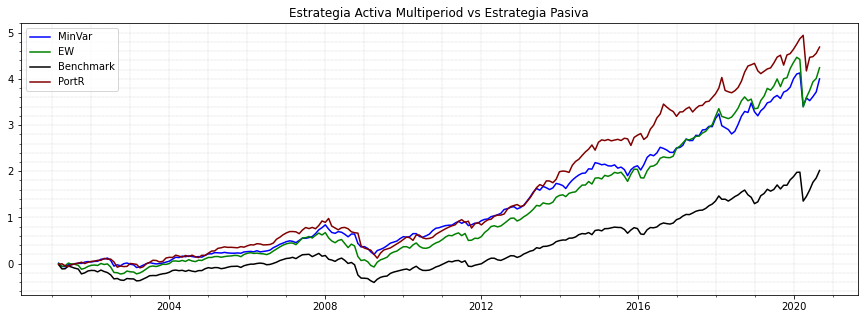

In [32]:
plt.figure(figsize=(15,5))
plt.title('Estrategia Activa Multiperiod vs Estrategia Pasiva')
plt.plot(((1+results.iloc[:,0]).cumprod()-1),c="b",ls="-",lw=1.5,label='MinVar')
plt.plot(((1+results.iloc[:,1]).cumprod()-1),c="g",ls="-",lw=1.5,label='EW')
plt.plot(((1+results.iloc[:,2]).cumprod()-1),c="k",ls="-",lw=1.5,label='Benchmark')
plt.plot(((1+results.iloc[:,3]).cumprod()-1),c="maroon",ls="-",lw=1.5,label='PortR')
#plt.plot(((1+results.iloc[:,4]).cumprod()-1),c="sienna",ls="-",lw=1.5,label='PortRc')
#plt.title('Me comieron la Ganancia los Fees')
plt.minorticks_on()
plt.grid(which='major',linestyle=':',linewidth='0.3',color='grey')
plt.grid(which='minor',linestyle=':',linewidth='0.3',color='grey')
plt.legend()

plt.show()


#### Performance Relativa
- Visualizar retornos anuales
- Compara la estrategia activa vs estrategia pasiva

In [33]:
# Estrategia activa
active = ((1+results.PortR).cumprod())
active = active.resample('Y').last()/active.resample('Y').first()-1
active = active.groupby(active.index.year).max()*100

# Estrategia pasiva
pasive = MktRF.resample('Y').last()/MktRF.resample('Y').first()-1
pasive = pasive.groupby(pasive.index.year).max()*100
pasive.columns = ['Benchmark']


# DataFrame
year_strat = pd.concat([active,pasive],axis=1).dropna()

Text(0.5, 0, '')

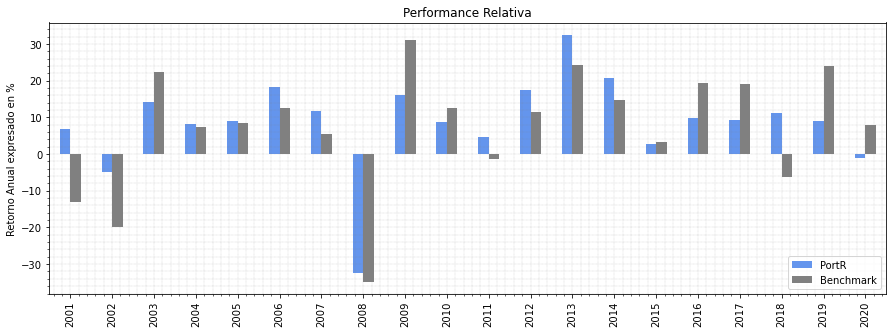

In [34]:
ax = year_strat.plot(kind="bar",figsize=(15,5),color=['cornflowerblue','grey'])
ax.legend(loc='lower right')
ax.minorticks_on()
ax.grid(which='major',linestyle=':',linewidth='0.3',color='grey')
ax.grid(which='minor',linestyle=':',linewidth='0.3',color='grey')
ax.set_title('Performance Relativa')
ax.set_ylabel('Retorno Anual expresado en %')
ax.set_xlabel('')


#### Resumen estadístico anual
- Avg Return
- Median
- CAGR
- Volatility
- Skewness
- Kurtosis
- Sharpe ratio
- Max DD

#### Metricas Estrategia Activa

In [35]:
Ret = np.round((((1+results.PortR.mean())**12)-1)*100,3)
print('Ret      :',Ret,'%')
Median = np.round((((1+results.PortR.median())**12)-1)*100,3)
print('Median   :',Median,'%')
CAGR = np.round(((1+results.PortR).cumprod()-1)[-1]*100,3)
print('CAGR     :',CAGR,'%')
StdDev = np.round(results.PortR.std()*(12**0.5)*100,3)
print('StdDev   :',StdDev,'%')
Skewness = np.round(results.PortR.skew(),3)
print('Skewness :',Skewness)
Kurtosis = np.round(results.PortR.kurtosis(),3)
print('Kurtosis :',Kurtosis)
Sharpe = np.round((Ret/StdDev),3)
print('Sharpe   :', Sharpe)
Max = np.round(results.PortR.max()*100,3)
print('Max      :', Max,'%')
Min = np.round(results.PortR.min()*100,3)
print('Min      :', Min,'%')

Ret      : 9.987 %
Median   : 15.543 %
CAGR     : 468.819 %
StdDev   : 11.268 %
Skewness : -1.316
Kurtosis : 4.904
Sharpe   : 0.886
Max      : 9.893 %
Min      : -16.543 %


#### Drawdown 

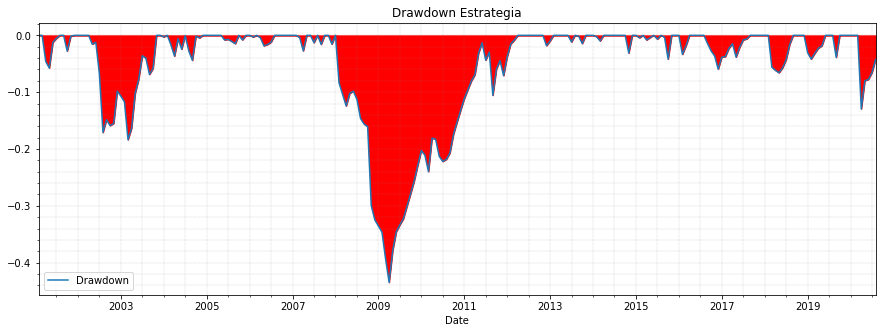

Max DD: -43.482 %


In [36]:
numerador = ((1+results.PortR).cumprod())-((1+results.PortR).cumprod()).cummax()
denominador = ((1+results.PortR).cumprod()).cummax()
Drawdown = numerador/denominador

plt.figure(figsize=(15,5))
plt.title('Drawdown Estrategia')
Drawdown.plot(label='Drawdown')
plt.minorticks_on()
plt.grid(which='major',linestyle=':',linewidth='0.3',color='grey')
plt.grid(which='minor',linestyle=':',linewidth='0.3',color='grey')
plt.legend()
plt.fill_between(Drawdown.index,Drawdown, color = 'red')
plt.show()
print('Max DD:', np.round(Drawdown.min()*100,3),'%')

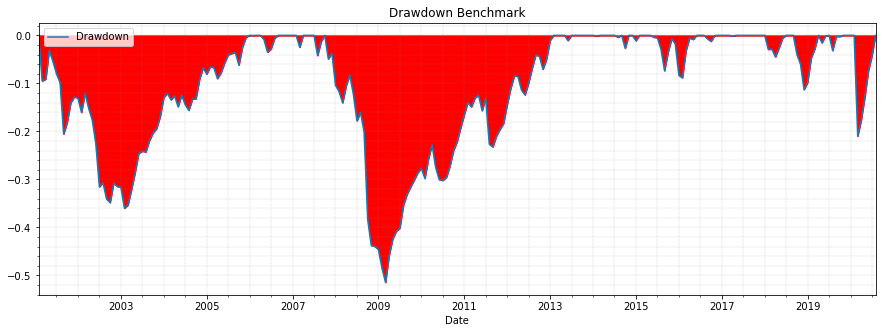

Max DD: -51.468 %


In [37]:
numerador = ((1+results.Benchmark).cumprod())-((1+results.Benchmark).cumprod()).cummax()
denominador = ((1+results.Benchmark).cumprod()).cummax()
Drawdown = numerador/denominador

plt.figure(figsize=(15,5))
plt.title('Drawdown Benchmark')
Drawdown.plot(label='Drawdown')
plt.minorticks_on()
plt.grid(which='major',linestyle=':',linewidth='0.3',color='grey')
plt.grid(which='minor',linestyle=':',linewidth='0.3',color='grey')
plt.legend()
plt.fill_between(Drawdown.index,Drawdown, color = 'red')
plt.show()
print('Max DD:', np.round(Drawdown.min()*100,3),'%')

#### Performance Historica

In [38]:
year = ['2005','2006','2007','2008','2009','2010',
        '2011','2012','2013','2014','2015','2016',
        '2017', '2018','2019','2020']
month = ['Ene','Feb','Mar','Abr','May','Jun',
         'Jul','Ago','Sep','Oct','Nov','Dic']
idx = pasive.iloc[6:].index
mat_ret = []

for y in year:
    ret = results.PortR[y]
    ret = np.round(ret.groupby(ret.index.month).mean()*100,2)
    mat_ret.append(ret)

mat_ret = pd.DataFrame(mat_ret)
mat_ret = pd.DataFrame(mat_ret.values,index=idx,columns=month)
mat_ret['Estrategia YTD'] = np.round(active.iloc[4:].values)
mat_ret['Benckmark YTD'] = np.round(pasive.iloc[6:].values)

mat_ret

,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Estrategia YTD,Benckmark YTD
Date,,,,,,,,,,,,,,
2005,3.62,0.30,4.38,0.89,1.49,-0.80,0.09,-0.36,-0.41,1.79,-0.80,2.18,9.0,9.0
2006,1.62,-0.30,1.94,-0.42,-1.43,0.22,0.44,2.20,5.74,2.84,3.34,2.47,18.0,13.0
2007,1.76,0.08,-0.38,-2.37,4.83,3.10,-1.29,1.43,-1.59,4.02,5.35,-1.55,12.0,6.0
2008,4.46,-8.36,-2.26,-2.24,2.53,0.44,-1.61,-3.76,-1.18,-0.55,-16.54,-3.58,-32.0,-35.0
2009,-1.60,-1.65,-7.12,-6.91,9.89,5.34,1.86,1.65,3.25,3.08,3.09,3.72,16.0,31.0
2010,3.43,-1.02,-3.69,7.76,-0.24,-3.65,-1.17,0.47,1.43,4.16,2.60,2.44,9.0,12.0
2011,2.31,1.79,1.72,1.21,4.07,1.89,-3.10,1.48,-7.83,5.13,1.62,-2.77,5.0,-1.0
2012,3.55,2.35,0.68,3.29,1.20,-0.00,1.18,5.04,2.56,1.07,0.89,-1.83,18.0,12.0
2013,0.84,3.60,3.75,4.43,4.48,2.45,-1.17,4.24,-0.15,-1.30,2.67,5.79,33.0,24.0


#### Histograma
- Histograma de Retornos
- Kernel Density Estimation (KDE) para estimar la función de densidad de probabilidad

Text(0.5, 0.98, 'Histograma de Retornos Mensuales')

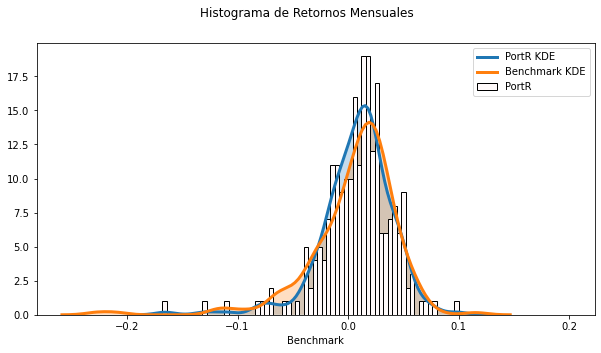

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
counts, bins, bars = plt.hist(results.PortR, bins=100, range=(-0.2,0.2),
                              color='snow', edgecolor='k', label='PortR')
sns.distplot(results.PortR,hist=False,kde=True,
             kde_kws={'shade': True, 'linewidth': 3}, label='PortR KDE')
sns.distplot(results.Benchmark,hist=False,kde=True,
            kde_kws={'shade': True, 'linewidth': 3}, label='Benchmark KDE')
plt.legend()
plt.suptitle("Histograma de Retornos Mensuales")

### Referencias
- Eugene Fama y Kenneth French.(7 de septiembre de 2020). Current Research Returns. Recuperado el 07-09-2020 de http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5emerging.html
- Petter N. Kolm, Reha Tütüncü, Frank J. Fabozzi (2013). 60 Years of portfolio optimization: Practical challenges and current trends.